### Xception - Dog breed Detection



I will be performing following steps :
1. Importing the data 
2. Data Argumentation And Visualization 
3. Importing the Xception ( Transfer learning ) 
4. Fully Connected layer 
5. Model Training 
6. Accuracy And Loss Visualization
7. Test the model




# **ABOUT THE DATASET **

The dataset used here contains images of 137 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.


## 1. DATASET EXPLORATION 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tf_explain
#!pip install split-folders
#!conda install -y gdown

     |████████████████████████████████| 43 kB 1.0 MB/s 


### 1.1 Libraries and data

In [4]:
import os
import pandas as pd

import xml.etree.ElementTree as ET
#import gdown
import time
import math
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

from keras.utils import np_utils
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tf_explain.core.activations import ExtractActivations

from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline
from sklearn.metrics import classification_report

from PIL import Image
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
print("Loaded all libraries")

Loaded all libraries


In [8]:
image_path = '/content/drive/MyDrive/DL/Project/images/Images/'
#image_path ='/media/marco/DATA/OC_Machine_learning/section_6/DATA/Images/'
num_of_categories = 137
image_size = 299
batch_size = 16

In [9]:
breed_list = sorted(os.listdir(image_path))

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

137 breeds


In [10]:
# Define a time counter function to test the algorythms performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

### 1.2 Generate a data folder with cropped pictures 

In [11]:
os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))



Created 137 folders to store cropped images of the different breeds.


In [12]:
%%time
for breed in os.listdir('data'):
    for file in os.listdir('/content/drive/MyDrive/DL/Project/annotations/Annotations/{}'.format(breed)):
        img = Image.open('/content/drive/MyDrive/DL/Project/images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('/content/drive/MyDrive/DL/Project/annotations/Annotations/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bodybndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bodybndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bodybndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bodybndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((image_size, image_size))
        img.save('data/' + breed + '/' + file + '.jpg')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


CPU times: user 4min 7s, sys: 22.3 s, total: 4min 29s
Wall time: 1h 27min 9s


Print cropped images

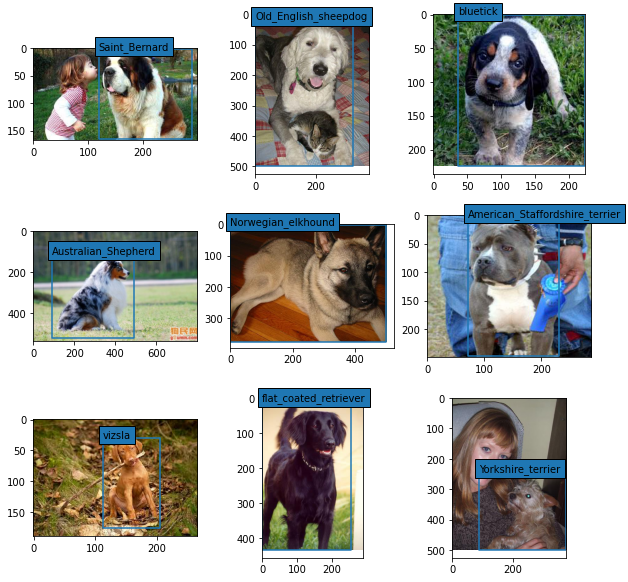

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(331 + i) # showing 9 random images
    breed = np.random.choice(breed_list) # random breed
    dog = np.random.choice(os.listdir('/content/drive/MyDrive/DL/Project/annotations/Annotations/' + breed)) # random image 
    img = Image.open('/content/drive/MyDrive/DL/Project/images/Images/' + breed + '/' + dog + '.jpg') 
    tree = ET.parse('/content/drive/MyDrive/DL/Project/annotations/Annotations/' + breed + '/' + dog) # init parser for file given
    root = tree.getroot() # idk what's it but it's from documentation
    objects = root.findall('object') # finding all dogs. An array
    plt.imshow(img) # displays photo
    for o in objects:
        bndbox = o.find('bodybndbox') # reading border coordinates
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin]) # showing border
        plt.text(xmin, ymin, o.find('name').text, bbox={'ec': None}) # printing breed

### 1.2.1 Define paths (X) and labels (y)

In [14]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [15]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

### 1.3 Define my own image generator with custom augmentation

In [16]:
class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = cv2.imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.Sometimes(0.5,
                    
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-40, 40),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

### 1.4 Split X and y into train, validation and test

In [17]:
x_train, x_test, y_train, y_test = train_test_split(paths, targets, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

train_ds = ImageGenerator(x_train, y_train, batch_size=32, shape=(image_size, image_size,3), augment=True)
val_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)
test_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)

## 2. MODEL PREPARATION 

### 2.1 Importing the Xception CNN

In [19]:
base_model = tf.keras.applications.xception.Xception(weights='imagenet',include_top=False, pooling='avg')#Summary of Xception Model

base_model.trainable = False


#pre_trained_model.summary()



83697664/83683744 [==============================] - 0s 0us/step


In [20]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

### 2.2 Fully connected layer

In [21]:
flat_dim = 5 * 5 * 2048

my_model = Sequential(base_model)

#my_model.add(Flatten())
#my_model.add(Dropout(0.1)) # dropout added
my_model.add(Dense(1032, activation='relu',input_dim=flat_dim))
my_model.add(Dense(512, activation='relu'))
#my_model.add(Dropout(0.1))
my_model.add(Dense(256, activation='relu'))
my_model.add(Dense(137, activation='softmax'))



In [22]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 1032)              2114568   
                                                                 
 dense_1 (Dense)             (None, 512)               528896    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 137)               35209     
                                                                 
Total params: 23,671,481
Trainable params: 2,810,001
Non-trainable params: 20,861,480
_________________________________________________________________


### 2.3 Define callbacks and compile the model

[1e-05, 6.505114555849587e-06, 1.3998974074878144e-05, 2.1158257692363077e-05, 2.6349806140466085e-05, 2.9032781503571898e-05, 2.9396559030789573e-05, 2.7979491786027585e-05, 2.540182222438155e-05, 2.2217993076484613e-05, 1.885603456913674e-05, 1.5609303737669377e-05, 1.265427690063973e-05, 1.0077640616334645e-05, 7.903437440340427e-06, 6.116030942221757e-06, 4.677609611772819e-06, 3.5404805065519026e-06, 2.655051675737932e-06, 1.9745568653868732e-06, 1.457488127964179e-06, 1.068520029068309e-06, 7.785125464502897e-07, 5.640054703120814e-07, 4.0647805168961314e-07]


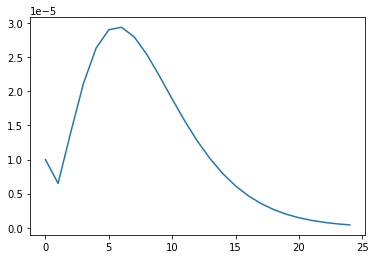

In [24]:
###################
total_epoch = 10
learning_rate_init = 0.00001
###################

def lr_scheduler(epoch):
    epoch += 1
   
    if epoch == 1:
        return learning_rate_init
    
    elif epoch >= 2 and epoch <= 40:
        return (0.2*epoch**3)*math.exp(-0.45*epoch)*learning_rate_init
    
    else:
        return lr_scheduler(40-1)
    

stage = [i for i in range(0,25)]
learning_rate = [lr_scheduler(x) for x in stage]
plt.plot(stage, learning_rate)
print(learning_rate)

In [25]:
# Callbacks

scheduler = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience = 3, mode='max', min_delta=1, verbose=1)

In [26]:
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 3. TRAINING THE MODEL

In [27]:
process_time_starts()

hist = my_model.fit_generator(generator=train_ds, steps_per_epoch=400, validation_data=val_ds,  validation_steps=90, epochs=10, callbacks=[scheduler])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until



Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/10
400/400 [==============================] - 142s 323ms/step - loss: 4.8063 - accuracy: 0.0858 - val_loss: 4.6107 - val_accuracy: 0.2389 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 6.505114555849587e-06.
Epoch 2/10
400/400 [==============================] - 141s 353ms/step - loss: 4.4661 - accuracy: 0.2858 - val_loss: 4.2027 - val_accuracy: 0.4042 - lr: 6.5051e-06

Epoch 00003: LearningRateScheduler setting learning rate to 1.3998974074878144e-05.
Epoch 3/10
400/400 [==============================] - 140s 350ms/step - loss: 3.6647 - accuracy: 0.4382 - val_loss: 2.8274 - val_accuracy: 0.5726 - lr: 1.3999e-05

Epoch 00004: LearningRateScheduler setting learning rate to 2.1158257692363077e-05.
Epoch 4/10
400/400 [==============================] - 140s 349ms/step - loss: 2.2374 - accuracy: 0.5852 - val_loss: 1.4375 - val_accuracy: 0.7288 - lr: 2.1158e-05

Epoch 00005: LearningRate

In [28]:
time_elapsed()

The process took: 0hour:23min:34sec


### 4. LOSS AND ACCURACY VISUALIZATION 

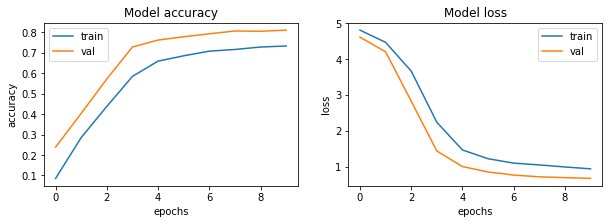

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 5. Save model and parameters

In [30]:
my_model.save('my_model_xception.h5', overwrite=True) 
my_model.save_weights('dog_breed_xcept_weights.h5', overwrite=True)
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk


### 6. Test model accuracy

In [31]:
test_loss, test_accuracy = my_model.evaluate_generator(generator=test_ds,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test results 
 Loss: 0.6717067956924438 
 Accuracy 0.8125


In [32]:

#report = classification_report(test_ds.classes, pred, target_names=class_to_id)
#print(report)

## 7. Predict new images

In [33]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((299, 299))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = image.imread(filename)
    img = preprocess_input(img)
    probs = my_model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

88.69% 	 malinois
5.52% 	 Black_sable
2.58% 	 German_shepherd
0.48% 	 kelpie
0.33% 	 dingo


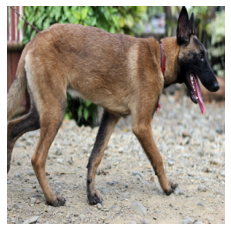

In [34]:
download_and_predict("https://cdn.pixabay.com/photo/2018/08/12/02/52/belgian-mallinois-3599991_1280.jpg",
                     "test_1.jpg")



34.89% 	 Welsh_springer_spaniel
19.28% 	 Brittany_spaniel
8.80% 	 golden_retriever
7.82% 	 English_setter
6.62% 	 Irish_setter


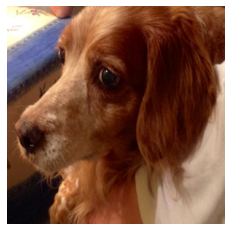

In [35]:
download_and_predict("http://giandonet.altervista.org/Marco/ala.JPG",
                     "test_2.jpg")


32.48% 	 toy_terrier
24.08% 	 boxer
13.44% 	 Boston_bull
6.17% 	 French_bulldog
4.16% 	 Italian_greyhound


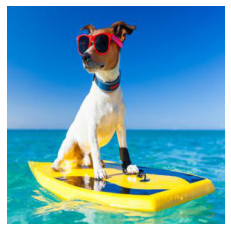

In [36]:
download_and_predict("http://giandonet.altervista.org/Marco/surfingdog.jpg",
                     "test_3.jpg")